In [5]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'C://Users//hp//Desktop//Areca_leaves'
width=256
height=256
depth=3

In [7]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [8]:
image_list, label_list = [], []
l=[]
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                l.append(image)
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Diseased ...
[INFO] Processing Healthy ...
[INFO] Image loading completed


In [9]:
image_size = len(image_list)

In [10]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
#pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [11]:
print(label_binarizer.classes_)

['Diseased' 'Healthy']


In [12]:
print(image_labels)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [13]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [14]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [15]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [16]:
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

#Create models architecture
model = Sequential()

#Add the first layer
model.add( Conv2D(32, (3,3), activation='relu', input_shape=inputShape))

#Add a pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

#Add another convolutional layer
model.add( Conv2D(32, (3,3), activation='relu'))

#Add another pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

#Add a flatenning layer
model.add(Flatten())

#Add a layer with 1000 neurons
model.add(Dense(1000, activation='relu'))

#Add a dropout layer
model.add(Dropout(0.5))

#Add a layer with 500 neurons
model.add(Dense(500, activation='relu'))

#Add a dropout layer
model.add(Dropout(0.5))

#Add a layer with 250 neurons
model.add(Dense(250, activation='relu'))

#Add a layer with 10 neurons
model.add(Dense(2, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              123009000 
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0

In [42]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam', metrics = ['accuracy'])

In [43]:
history = model.fit(x_train, y_train, batch_size= 256,
                 epochs = 30, 
                 validation_split = 0.2)

Epoch 1/30
1/1 [==============================] - 0s 420ms/step - loss: 0.6893 - accuracy: 0.5000 - val_loss: 12.5346 - val_accuracy: 0.5000
Epoch 2/30
1/1 [==============================] - 0s 189ms/step - loss: 10.9045 - accuracy: 0.5625 - val_loss: 28.5306 - val_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 0s 181ms/step - loss: 28.4560 - accuracy: 0.4375 - val_loss: 11.6131 - val_accuracy: 0.5000
Epoch 4/30
1/1 [==============================] - 0s 190ms/step - loss: 10.5759 - accuracy: 0.4375 - val_loss: 2.6782 - val_accuracy: 0.5000
Epoch 5/30
1/1 [==============================] - 0s 180ms/step - loss: 5.9228 - accuracy: 0.6250 - val_loss: 5.7700 - val_accuracy: 0.5000
Epoch 6/30
1/1 [==============================] - 0s 186ms/step - loss: 8.4977 - accuracy: 0.5625 - val_loss: 3.4320 - val_accuracy: 0.5000
Epoch 7/30
1/1 [==============================] - 0s 200ms/step - loss: 4.6664 - accuracy: 0.6250 - val_loss: 0.9414 - val_accuracy: 0.5000
Epoch 8/30
1/1

In [2]:
from keras.models import load_model

In [95]:
#model.save("areca_leaves.h5")

In [19]:
#mode = load_model("areca_leaves.h5")

In [44]:
model.evaluate(x_test, y_test)[1]

1/1 [==============================] - 0s 997us/step - loss: 0.0067 - accuracy: 1.0000


1.0

In [45]:
pwd

'C:\\Users\\hp\\Downloads\\Compressed\\leaf_disease_detection-main'

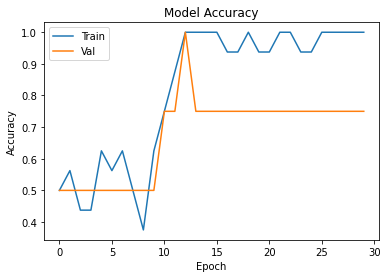

In [46]:
#Visualize model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

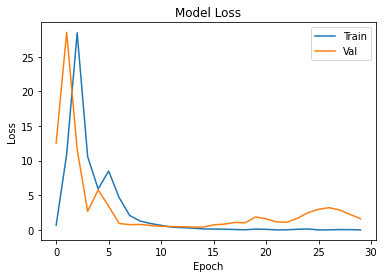

In [47]:
#Visualize model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

In [48]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
1/1 [==============================] - 0s 0s/step - loss: 0.0067 - accuracy: 1.0000
Test Accuracy: 100.0


In [134]:
#image_dir="C:\\Users\\hp\\Desktop\\Areca dataset\\plant_folder\\Leaf\\diseased_leaf (3).jpg"
#image_dir="C:\\Users\\hp\\Desktop\\Areca dataset\\plant_folder\\nuts\\healthy_nut (6).jpg"
#image_dir="C:\\Users\\hp\\Desktop\\Areca dataset\\plant_folder\\trunk\\Healthy (4).jpg"
image_dir = "C://Users//hp//Downloads//Ayurvedic+Healing_Betel+leaf+versus+tobacco.jpg"
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [135]:
result=model.predict(npp_image)

print(result)

[[0.04154948 0.9584505 ]]


In [136]:
#itemindex = np.where(result==np.max(result))
#print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

for i in range(len(result[0])):
    print(label_binarizer.classes_[i]+" "+str(round(result[0][i]*100,2))+ " %")
    

Diseased 4.15 %
Healthy 95.85 %
